In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import time

import datetime as dt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [2]:
gold = (
    yf
    .download("GDX",
                    start = dt.datetime(2011, 9, 9),
                    end = dt.datetime(2023, 9, 8)
                   ))

[*********************100%%**********************]  1 of 1 completed


In [3]:
gold.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-31,29.52,29.629999,29.040001,29.260000,28.787304,16439500
2023-09-01,29.66,29.850000,29.059999,29.090000,28.620049,20820200
2023-09-05,28.82,29.030001,28.370001,28.490000,28.029741,19547900
2023-09-06,28.33,28.740000,28.240000,28.469999,28.010065,14809700
2023-09-07,28.41,28.459999,28.160000,28.280001,27.823135,13897200


In [4]:
def sma_mean_reversion(df, column='WMT', sma_window=41, threshold='int', threshold_value=4, 
                      strategy='long_short', plot=True, plot_window=None):
    """
    Mean reversion trading strategy based on absolute or percentage deviation from SMA.
    Generates buy and sell signals based on deviation thresholds and plots the results.

    Parameters:
    df (pd.DataFrame): DataFrame containing the price series.
    column (str): Column name of the price series.
    sma_window (int): Window size for calculating the SMA.
    threshold (str): 'int' for absolute deviation or 'float' for percentage deviation.
    threshold_value (float): Threshold value (absolute if 'int', percentage if 'float').
    strategy (str): Strategy type: 'long', 'short', or 'long_short'.
    plot (bool): If True, displays the plot of deviation from SMA with signals.
    plot_window (int, optional): Number of recent values to plot. If None, plots all values.

    Returns:
    pd.DataFrame: A DataFrame with added columns for SMA, deviation, and signals.
    """
    df = df[[column]].copy()
    df['SMA'] = df[column].rolling(window=sma_window).mean()

    # Calculate deviation based on the threshold type
    if threshold == 'int':
        df['deviation'] = df[column] - df['SMA']
        upper_threshold = threshold_value
        lower_threshold = -threshold_value
    elif threshold == 'float':
        df['deviation'] = (df[column] - df['SMA']) / df['SMA'] * 100  # % deviation
        upper_threshold = threshold_value
        lower_threshold = -threshold_value

    # Generate buy (1), sell (-1), and hold (0) signals based on strategy
    if strategy == 'long':
        df['Signals'] = np.where(df['deviation'] < lower_threshold, 1, 0)
    elif strategy == 'short':
        df['Signals'] = np.where(df['deviation'] > upper_threshold, -1, 0)
    elif strategy == 'long_short':
        df['Signals'] = np.where(df['deviation'] > upper_threshold, -1, 
                                 np.where(df['deviation'] < lower_threshold, 1, 0))

    # Limit data for plotting if plot_window is specified
    plot_data = df if plot_window is None else df.tail(plot_window)

    # Plot if requested
    if plot:
        plt.figure(figsize=[15, 8])
        plot_data['deviation'].dropna().plot(color="grey", lw=1, label="Deviation (%)" if threshold == 'float' else "Deviation")
        plt.axhline(upper_threshold, color="blue", ls="--", lw=2, label=f"Upper Threshold (+{threshold_value}{'%' if threshold == 'float' else ''})")
        plt.axhline(0, color="green", ls="--", lw=1.5, alpha=0.6)
        plt.axhline(lower_threshold, color="blue", ls="--", lw=2, label=f"Lower Threshold (-{threshold_value}{'%' if threshold == 'float' else ''})")

        # Plot buy and sell signals at fixed y-values of 1 and -1
        buy_signals = plot_data[plot_data['Signals'] == 1]
        sell_signals = plot_data[plot_data['Signals'] == -1]

        plt.plot(buy_signals.index, [1] * len(buy_signals), 'go', markersize=8, label="Long Signals", alpha=0.6)
        plt.plot(sell_signals.index, [-1] * len(sell_signals), 'ro', markersize=8, label="Short Signals", alpha=0.6)

        # Highlight overbought and oversold areas
        plt.fill_between(plot_data.index, upper_threshold, plot_data["deviation"], 
                         where=(plot_data["deviation"] > upper_threshold), 
                         color="red", alpha=0.2, label="Overbought Zone")
        plt.fill_between(plot_data.index, lower_threshold, plot_data["deviation"], 
                         where=(plot_data["deviation"] < lower_threshold), 
                         color="green", alpha=0.2, label="Oversold Zone")

        plt.title(f"Mean Reversion with Long/Short Signals (Threshold: {threshold_value}{'%' if threshold == 'float' else ''} from {sma_window}-Day SMA)", 
                  fontsize=14, color='darkred')
        plt.xlabel("Date", fontsize=12)
        plt.ylabel('Deviation (%)' if threshold == 'float' else 'Deviation', fontsize=12)
        plt.legend(loc="best")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df

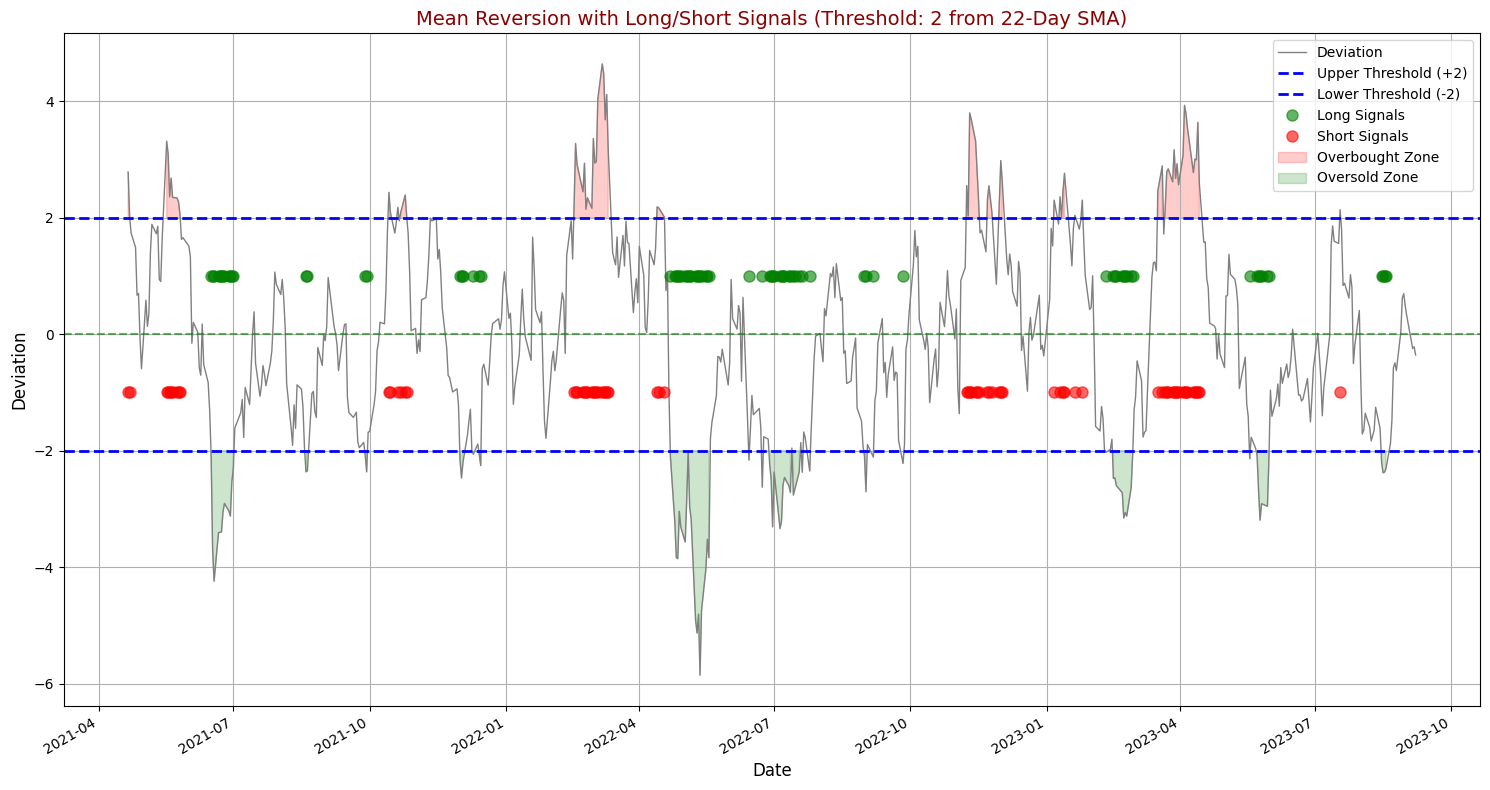

In [5]:
gold_ma22_reversion = (
    sma_mean_reversion(gold, 
                      column='Close', 
                      sma_window=22, threshold='int', threshold_value=2, 
                      plot=True, plot_window = 600))

In [6]:
gold_ma22_reversion

,Close,SMA,deviation,Signals
Date,,,,
2011-09-09,65.800003,NaN,NaN,0
2011-09-12,63.900002,NaN,NaN,0
2011-09-13,64.389999,NaN,NaN,0
2011-09-14,63.169998,NaN,NaN,0
2011-09-15,62.799999,NaN,NaN,0
...,...,...,...,...
2023-08-31,29.260000,28.778636,0.481364,0
2023-09-01,29.090000,28.770000,0.320000,0
2023-09-05,28.490000,28.734091,-0.244091,0


In [7]:
def strategy_calculation(df, date_col='Date', signal_col='Combined Signal', price_col='Price', strategy='long_only'):
    """
    Calculate strategy-related columns based on the selected trading strategy without setting Date as the index initially.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing columns for date, signal, and price.
    date_col (str): Column name for dates.
    signal_col (str): Column name for trading signals (1 for long, -1 for short).
    price_col (str): Column name for prices.
    strategy (str): Either 'long_only', 'short_only', or 'long_short'. Determines the trading strategy.

    Returns:
    pd.DataFrame: DataFrame with additional columns for 'Price Return', 'Price Cum Return',
                  'Strategy Return', 'Strategy Cum Return', 'High Watermark', 'Drawdown', and 'Max Drawdown'.
    """
    
    # Calculate log returns for prices
    df['Price Return'] = np.log(df[price_col] / df[price_col].shift(1)).fillna(0)

    # Calculate cumulative return of the price itself (Price Cum Return)
    df['Price Cum Return'] = df['Price Return'].cumsum().apply(np.exp)

    # Use shifted signal directly based on the strategy
    if strategy == 'long_only':
        shifted_signal = df[signal_col].shift(1).apply(lambda x: 1 if x == 1 else 0)
    elif strategy == 'short_only':
        shifted_signal = df[signal_col].shift(1).apply(lambda x: -1 if x == -1 else 0)
    elif strategy == 'long_short':
        shifted_signal = df[signal_col].shift(1)

    # Calculate strategy return based on shifted signal
    df['Strategy Return'] = df['Price Return'] * shifted_signal # OK

    # Calculate cumulative return based on strategy return (Strategy Cum Return)
    df['Strategy Cum Return'] = df['Strategy Return'].cumsum().apply(np.exp)

    # Calculate high watermark and drawdown based on strategy cumulative return
    df['High Watermark'] = df['Strategy Cum Return'].cummax()
    df['Drawdown'] = (df['Strategy Cum Return'] - df['High Watermark']).clip(upper=0)
    df['Max Drawdown'] = df['Drawdown'].cummin()

    # Set the Date column as the index at the end
    df.set_index(date_col, inplace=True)

    return df

In [8]:
strategy_cal = (
    strategy_calculation(gold_ma22_reversion.reset_index(), date_col='Date', 
                         signal_col='Signals', price_col='Close', strategy='long_short'))
strategy_cal.tail(10)

,Close,SMA,deviation,Signals,Price Return,Price Cum Return,Strategy Return,Strategy Cum Return,High Watermark,Drawdown,Max Drawdown
Date,,,,,,,,,,,
2023-08-24,28.680000,29.171818,-0.491818,0,-0.002090,0.435866,-0.0,1.777792,2.121056,-0.343264,-0.690336
2023-08-25,28.400000,29.024091,-0.624091,0,-0.009811,0.431611,-0.0,1.777792,2.121056,-0.343264,-0.690336
2023-08-28,29.000000,28.962727,0.037273,0,0.020907,0.440729,0.0,1.777792,2.121056,-0.343264,-0.690336
2023-08-29,29.530001,28.908636,0.621364,0,0.018111,0.448784,0.0,1.777792,2.121056,-0.343264,-0.690336
2023-08-30,29.520000,28.822727,0.697273,0,-0.000339,0.448632,-0.0,1.777792,2.121056,-0.343264,-0.690336
2023-08-31,29.260000,28.778636,0.481364,0,-0.008847,0.444681,-0.0,1.777792,2.121056,-0.343264,-0.690336
2023-09-01,29.090000,28.770000,0.320000,0,-0.005827,0.442097,-0.0,1.777792,2.121056,-0.343264,-0.690336
2023-09-05,28.490000,28.734091,-0.244091,0,-0.020841,0.432979,-0.0,1.777792,2.121056,-0.343264,-0.690336
2023-09-06,28.469999,28.684545,-0.214546,0,-0.000702,0.432675,-0.0,1.777792,2.121056,-0.343264,-0.690336


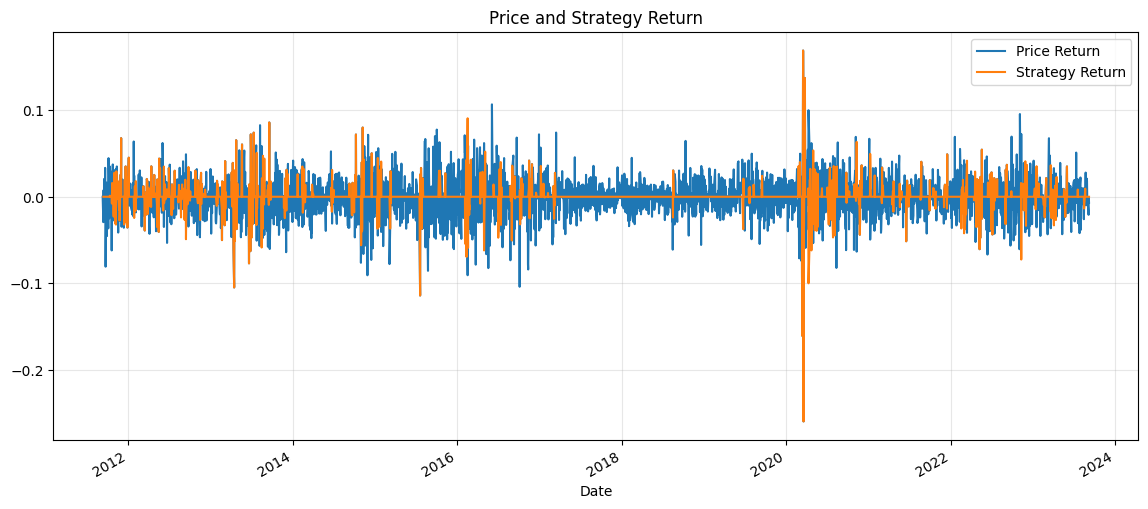

In [9]:
strategy_cal[['Price Return','Strategy Return']].plot(figsize=(14,6))
plt.grid(True, alpha = 0.3)
plt.legend()
plt.title('Price and Strategy Return');

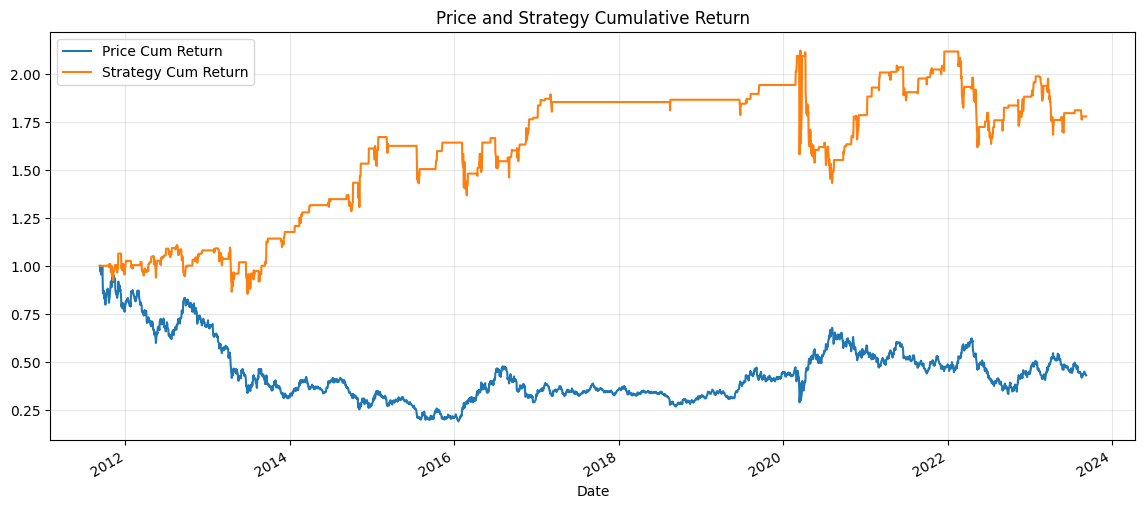

In [10]:
strategy_cal[['Price Cum Return','Strategy Cum Return']].plot(figsize=(14,6))
plt.grid(True, alpha = 0.3)
plt.legend()
plt.title('Price and Strategy Cumulative Return');

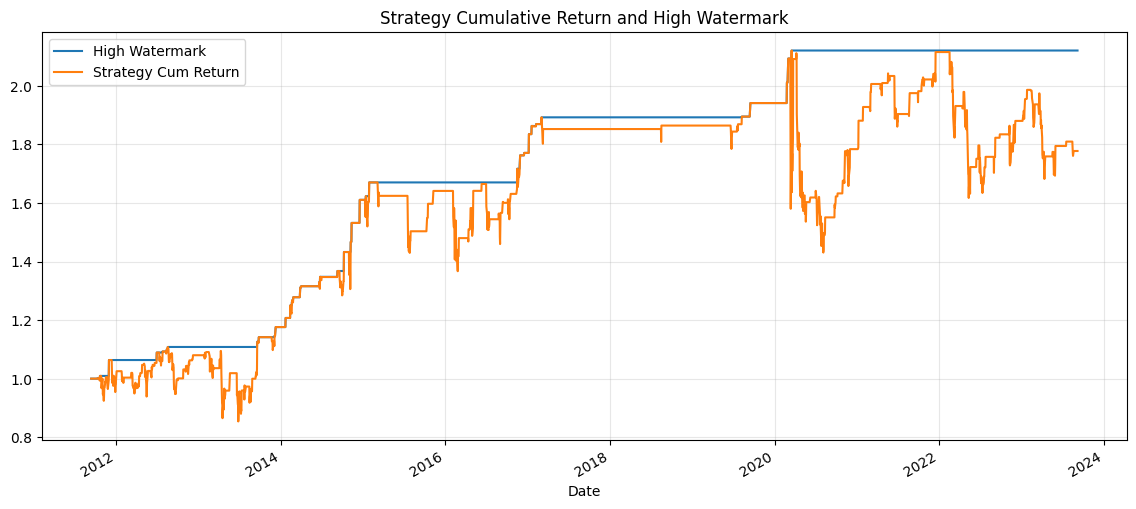

In [11]:
strategy_cal[['High Watermark','Strategy Cum Return']].plot(figsize=(14,6))
plt.grid(True, alpha = 0.3)
plt.legend()
plt.title('Strategy Cumulative Return and High Watermark');

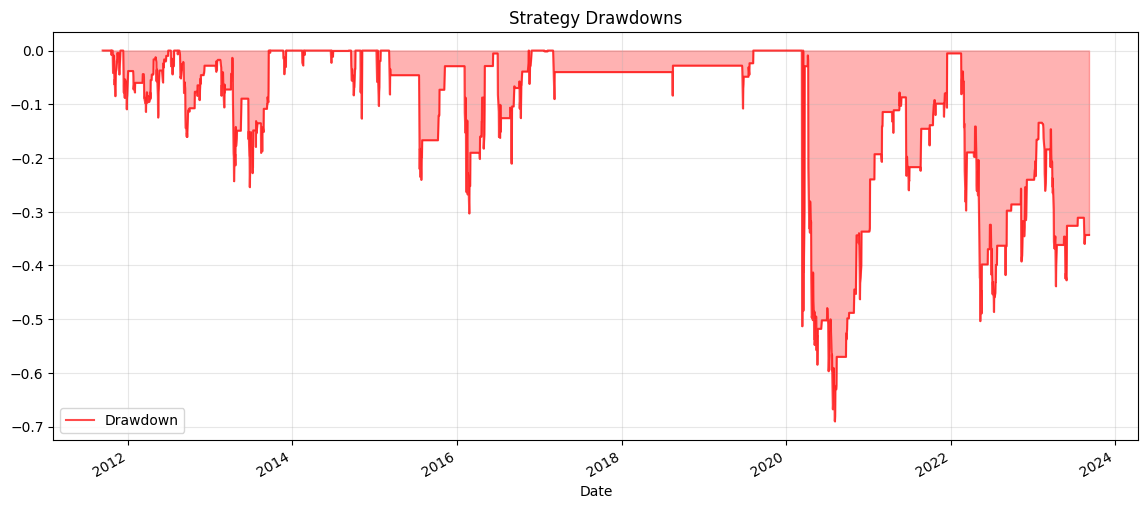

In [12]:
strategy_cal[['Drawdown']].plot(figsize=(14,6), color = 'red', alpha = 0.7)
plt.fill_between(strategy_cal.index, strategy_cal.Drawdown, color = 'red', alpha = 0.3
                )
plt.grid(True, alpha = 0.3)
plt.legend()
plt.title('Strategy Drawdowns');

In [13]:
def strategy_metrics(df, date_col='Date', signal_col='Combined Signal', price_col='Price', 
                     strategy='long_only', drawdown='max', timeframe = 1):
    """
    Extended version of strategy_calculation to compute and print additional metrics: Sharpe, CAGR, Max Drawdown, 
    and Drawdown Period (either max historical or ongoing drawdown).
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing date, signal, and price columns.
    - date_col (str): Name of the date column.
    - signal_col (str): Name of the trading signal column.
    - price_col (str): Name of the price column.
    - strategy (str): Trading strategy ('long_only', 'short_only', 'long_short').
    - drawdown (str): Type of drawdown period to calculate ('max' for historical max, 'current' for ongoing).
    - timeframe (int): Dynamic parameter to work with different time frame (e.g. daily data = 1; 2D = 0.5; half-day = 2...)
    
    Returns:
    - df (pd.DataFrame): DataFrame with strategy metrics columns.
    """
    # Call strategy_calculation to compute base strategy metrics
    df = strategy_calculation(df, date_col, signal_col, price_col, strategy)

    # Calculate periods per year to annualize Sharpe
    periods_per_year = 252 * timeframe # e.g. if data is half day then we have 504 periods per year
    
    # Calculate Sharpe Ratio (annualized, using 252 trading days)
    sharpe_ratio = np.sqrt(periods_per_year) * (df['Strategy Return'].mean() / df['Strategy Return'].std())

    # Calculate CAGR (annualized, using 365 days because we still bear opportunity cost for non-trading days)
    days_in_period = (df.index[-1] - df.index[0]).days
    cagr = df['Strategy Cum Return'].iloc[-1] ** (365 * timeframe/ days_in_period) - 1
    # 365 * timeframe equals to total number of periods per year based on the timeframe of the data, then divide by total days give 1/T

    # Calculate the maximum drawdown value
    max_drawdown = df['Max Drawdown'].min()

    # Drawdown period calculation based on the `drawdown` parameter
    if drawdown == 'current' and df['Drawdown'].iloc[-1] < 0:
        # Ongoing drawdown: calculate from last peak to current date
        drawdown_period = df.index[-1].to_pydatetime() - df['Drawdown'][df['Drawdown'] == 0].index[-1].to_pydatetime()
        drawdown_period_type = "Ongoing Drawdown Period (to current date)"
    else:
        # Historical max drawdown period: calculate between two consecutive zero drawdowns
        drawdown_periods = (
            df['Drawdown'][df['Drawdown'] == 0].index[1:].to_pydatetime() -
            df['Drawdown'][df['Drawdown'] == 0].index[:-1].to_pydatetime()   )
        drawdown_period = drawdown_periods.max()
        drawdown_period_type = "Longest Drawdown Period"

    # Print the calculated metrics
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"CAGR: {cagr:.2%}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    print(f"{drawdown_period_type}: {drawdown_period}")

In [14]:
(
    strategy_metrics(gold_ma22_reversion.reset_index(), date_col='Date', signal_col='Signals', price_col='Close', 
                     strategy='long_short', drawdown='current', timeframe = 1))

Sharpe Ratio: 0.22
CAGR: 4.91%
Maximum Drawdown: -69.03%
Ongoing Drawdown Period (to current date): 1269 days, 0:00:00
